<a href="https://colab.research.google.com/github/donyeun/AMLSII_19-20_SN18154195/blob/master/AMLS_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries and Variables

In [0]:
import pandas as pd
import os
import torch
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk

In [0]:
cfg = {
       'paths': {
           'train_folder_task_a': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/training/2017_English_final/GOLD/Subtask_A',
           'train_additional_dataset_filenames': ['livejournal-2014test-A.tsv', 'sms-2013test-A.tsv'],
           'test_file_task_a': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/testing/SemEval2017-task4-test/SemEval2017-task4-test.subtask-A.english.txt',

           'train_folder_task_b': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/training/2017_English_final/GOLD/Subtasks_BD',
           'test_file_task_b': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/testing/SemEval2017-task4-test/SemEval2017-task4-test.subtask-BD.english.txt',
       },
       'task_a': {
           'use_additional_dataset': True,
       },
       'preprocessing': {
           'tokenization': {
               'remove_twitter_handle': True,
               'preserve_case': False
           }
       },
}

# Load Dataset


## Preprocess Additional Dataset
In task A, there are some additional datasets that were given from the competition apart from the standard twitter corpus, which is sms and livejournal corpus. We can use both of these additional datasets, after we preprocess the formatting so that it matches the rest of the twitter datasets.

In [4]:
task_a_train_additional_dfs = {}

for filename in cfg['paths']['train_additional_dataset_filenames']:
  # read additional corpora
  task_a_train_additional_dfs[filename] = pd.read_csv(os.path.join(cfg['paths']['train_folder_task_a'], filename), sep='\t', header=None)
  
  if filename == 'livejournal-2014test-A.tsv':
    # remove the 0-th column from livejournal corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[0])
  elif filename == 'sms-2013test-A.tsv':
    # remove the 1st column from sms corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[1])
  
  # reset the column index to make it incremental
  task_a_train_additional_dfs[filename].columns = range(task_a_train_additional_dfs[filename].shape[1])
  
  print(task_a_train_additional_dfs[filename])

             0         1                                                  2
0     LJ111111  negative  I know I missed something here , but what does...
1     LJ111113   neutral  What do you think of Beside Ourselves as a tit...
2     LJ111114  positive                    :D I intend to be one someday .
3     LJ111117  negative  LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4     LJ111119   neutral                     LLLINKKK Some more mountains .
...        ...       ...                                                ...
1137  LJ113616  positive                     Maybe it was - his - fantasy ?
1138  LJ113618  negative  It was ok , but they always just seem so nervo...
1139  LJ113621  positive  It is streamable from YepRoc -- matter of fact...
1140  LJ113623  positive  comment telling me who you are , or how you fo...
1141  LJ113625   neutral  im on myspace ... ill try and find you and add...

[1142 rows x 3 columns]
          0         1                                          

## Make Datasets As Pandas' DataFrames



In [0]:
def append_txt_files_as_one_dataframe(folderpath, filename_keywords_list, additional_dataset_dfs=None):
  dataset_per_file_dfs = {}
  dataset_df = pd.DataFrame()
  filenames = os.listdir(folderpath)
  
  # open txt files (in tsv formatting)
  for filename in filenames:
    # if the filename contains a keyword in the filename_keywords_list, then open the txt file
    # this is to avoid opening unnecessary txt such as readme.txt file.
    if any(keyword in filename for keyword in filename_keywords_list):
      dataset_per_file_dfs[filename] = pd.read_csv(os.path.join(folderpath, filename), sep='\t', header=None)

  # combine the original dataset with additional dataset (if any)
  if additional_dataset_dfs is not None:
    for key, value in additional_dataset_dfs.items():
      dataset_per_file_dfs[key] = value

  # append all the files as one dataframe
  for key, value in dataset_per_file_dfs.items():
    # print(key, '\t', i, '\t', dataset_per_file_df[key].shape[0])
    dataset_df = dataset_df.append(dataset_per_file_dfs[key], ignore_index=True)
  return dataset_df

In [0]:
def clean_dataframe_format(df, new_column_name_list, drop_column_list=[]):
  df = df.drop(columns=drop_column_list)
  df.columns = new_column_name_list
  return df

In [7]:
if cfg['task_a']['use_additional_dataset']:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'], task_a_train_additional_dfs)
else:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'])
task_a_train_df = clean_dataframe_format(task_a_train_df, ['id', 'sentiment', 'text'], drop_column_list=[3])
task_a_train_df

,id,sentiment,text
0,637641175948763136,neutral,@SeeMonterey LOST - Sony cell phone with holid...
1,637651487762554881,neutral,"@PersonaSoda well yeah, that's third parties. ..."
2,637666734300905472,negative,Sony rewards app is like a lot of 19 y.o femal...
3,637668142110654468,neutral,@fakethom Have android tab and don't use phone...
4,637708370129125377,positive,Finally I get my ps4 back I sent it to Sony ca...
...,...,...,...
53363,10038,negative,Oki... Think i\u2019m confused... I only know ...
53364,11799,neutral,Yup... Ok i go home look at the timings then i...
53365,11945,neutral,Here got lots of hair dresser fr china.
53366,10154,neutral,no alh we are not discussing fromt he viewpoi...


In [8]:
task_b_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_b'], ['twitter'])
task_b_train_df = clean_dataframe_format(task_b_train_df, ['id', 'topic','sentiment', 'text'], drop_column_list=[4])
task_b_train_df

,id,topic,sentiment,text
0,628949369883000832,@microsoft,negative,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@microsoft,negative,@Microsoft how about you make a system that do...
2,629023169169518592,@microsoft,negative,I may be ignorant on this issue but... should ...
3,629179223232479232,@microsoft,negative,"Thanks to @microsoft, I just may be switching ..."
4,629226490152914944,@microsoft,positive,"Microsoft, I may not prefer your gaming branch..."
...,...,...,...,...
20434,520957142816530432,younique,positive,Check out the gorgeous products from Younique!...
20435,522889214036156417,younique,neutral,LADIES! BULK ORDER GOES IN TOMORROW AT 10PM C...
20436,521416045865992192,younique,positive,"Here is something fun for you: On the 14th, I..."
20437,522912399322394624,younique,positive,Get the best mascara in the industry here! Im ...


In [9]:
task_a_test_df = pd.read_csv(cfg['paths']['test_file_task_a'], sep='\t', header=None)
task_a_test_df = clean_dataframe_format(task_a_test_df, ['id', 'sentiment', 'text'])
task_a_test_df

,id,sentiment,text
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
...,...,...,...
11901,805699615781625856,positive,@dansen17 update: Zac Efron kissing a puppy ht...
11902,805701709356003328,neutral,#zac efron sex pic skins michelle sex https://...
11903,805701818357579776,neutral,First Look at Neighbors 2 with Zac Efron Shirt...
11904,805703557081075712,neutral,zac efron poses nude #lovely libra porn https:...


In [10]:
task_b_test_df = pd.read_csv(cfg['paths']['test_file_task_b'], sep='\t', header=None)
task_b_test_df = clean_dataframe_format(task_b_test_df, ['id', 'topic', 'sentiment', 'text'])
task_b_test_df

,id,topic,sentiment,text
0,801989272341453952,#ArianaGrande,positive,Ariana Grande KIIS FM Yours Truly CD listening...
1,801990978424962944,#ArianaGrande,positive,Ariana Grande White House Easter Egg Roll in W...
2,801996232553963008,#ArianaGrande,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
3,801998343442407040,#ArianaGrande,positive,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
4,802001659970744064,#ArianaGrande,positive,Hairspray Live! Previews at the Macy's Thanksg...
...,...,...,...,...
6064,805696468959002624,zac efron,positive,"Abby *talking about the Hamilton soundtrack"": ..."
6065,805699412257181697,zac efron,positive,can we like get zac efron or justin bieber for...
6066,805699615781625856,zac efron,positive,@dansen17 update: Zac Efron kissing a puppy ht...
6067,805701818357579776,zac efron,positive,First Look at Neighbors 2 with Zac Efron Shirt...


# Exploratory Data Analysis (EDA)

# Tokenization

In [11]:
tokenizer = nltk.tokenize.TweetTokenizer(
    strip_handles = cfg['preprocessing']['tokenization']['remove_twitter_handle'],
    preserve_case = cfg['preprocessing']['tokenization']['preserve_case']
)

def tokenize_text(text, tokenizer):
  tokenized_text = tokenizer.tokenize(
      text,
    )
  return tokenized_text

# Tokenisation Example
text = task_a_train_df.head(1)['text'].values[0]
print('original text : ', text)
print('tokenized text: ', tokenizer.tokenize(text))

original text :  @SeeMonterey LOST - Sony cell phone with holiday photos. Early Fri morning, Montreal transit plaza or no. 13 bus to airport. REWARD! Plz RT.
tokenized text:  ['lost', '-', 'sony', 'cell', 'phone', 'with', 'holiday', 'photos', '.', 'early', 'fri', 'morning', ',', 'montreal', 'transit', 'plaza', 'or', 'no', '.', '13', 'bus', 'to', 'airport', '.', 'reward', '!', 'plz', 'rt', '.']


In [0]:
task_a_train_df['tokenized'] = task_a_train_df.apply(
    lambda row: tokenize_text(
        row['text'],
        tokenizer
    ),
    axis=1
)

In [13]:
task_a_train_df

,id,sentiment,text,tokenized
0,637641175948763136,neutral,@SeeMonterey LOST - Sony cell phone with holid...,"[lost, -, sony, cell, phone, with, holiday, ph..."
1,637651487762554881,neutral,"@PersonaSoda well yeah, that's third parties. ...","[well, yeah, ,, that's, third, parties, ., son..."
2,637666734300905472,negative,Sony rewards app is like a lot of 19 y.o femal...,"[sony, rewards, app, is, like, a, lot, of, 19,..."
3,637668142110654468,neutral,@fakethom Have android tab and don't use phone...,"[have, android, tab, and, don't, use, phone, m..."
4,637708370129125377,positive,Finally I get my ps4 back I sent it to Sony ca...,"[finally, i, get, my, ps4, back, i, sent, it, ..."
...,...,...,...,...
53363,10038,negative,Oki... Think i\u2019m confused... I only know ...,"[oki, ..., think, i, \, u2019m, confused, ...,..."
53364,11799,neutral,Yup... Ok i go home look at the timings then i...,"[yup, ..., ok, i, go, home, look, at, the, tim..."
53365,11945,neutral,Here got lots of hair dresser fr china.,"[here, got, lots, of, hair, dresser, fr, china..."
53366,10154,neutral,no alh we are not discussing fromt he viewpoi...,"[no, alh, we, are, not, discussing, fromt, he,..."


## Word Cloud

In [0]:
def show_wordcloud(text, title, max_words=200):
  wc = WordCloud(
      max_words=max_words,
      background_color='white',
      ranks_only= frequency
  ).generate(text)

  print(wc.words_)

  fig = plt.figure(1, figsize=(12, 12))
  fig.suptitle(title)
  plt.imshow(wc)
  plt.show()

In [16]:
df = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['text'][4]
print(df)
# print(df.shape)
# show_wordcloud(str(df.values), 'judul', max_words=20000)

# print(df.shape)
word_string = "you verse wrote book stand titlea i you you you kampung"
print(type(word_string))
show_wordcloud(word_string, 'judul', max_words=20000)

Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft
<class 'str'>


NameError: ignored

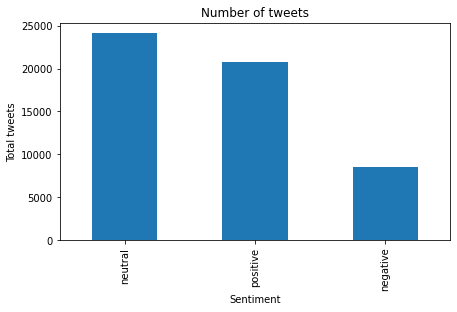

In [22]:
task_a_train_df['sentiment'].value_counts().plot(kind='bar',figsize=(7,4));
plt.title('Number of tweets');
plt.xlabel('Sentiment');
plt.ylabel('Total tweets');

In [24]:
task_b_train_df[task_b_train_df['text'].str.contains('not')]

,id,topic,sentiment,text
4,629226490152914944,@microsoft,positive,"Microsoft, I may not prefer your gaming branch..."
8,629797991826722816,@microsoft,negative,"After attempting a reinstall, it still bricks,..."
16,631543121407442946,@microsoft,negative,@Microsoft support for 365 has been terrible. ...
20,632536348419690496,@microsoft,negative,@eyesonfoxorg @Microsoft I'm still using Vista...
22,632810315227467776,@microsoft,negative,@MisterMetokur @Microsoft @ATT @NSAGov That's ...
...,...,...,...,...
20405,520384978820296705,yougov,negative,@LouiseBaldock great work; you may or may not ...
20407,519600072971927555,yougov,neutral,YouGov tonight shows 2% Labour lead. So headl...
20412,519201436102848512,yougov,neutral,IF tonight's YouGov shows another Tory lead th...
20419,520337071345795073,yougov,neutral,"Tonight's YouGov: Lab 35, Con 30, UKIP 15, Lib..."


                       positive  negative  neutral
careless world                6       1.0      3.0
jay-z                        59      14.0      NaN
kobe bryant                  13       4.0      3.0
justin                       69       9.0      NaN
bbc                          36      16.0      NaN
beyonce                      84       2.0      NaN
bentley                      65       3.0      NaN
icc                           5       1.0     13.0
paul mccartney              115       1.0      NaN
randy orton                  36       7.0      NaN
iran                         15      61.0      NaN
ant-man                     221       8.0      NaN
pride parade                 75       2.0      NaN
apple watch                  53       8.0      NaN
bernie sanders               76       9.0      NaN
ancelotti                    10       2.0      8.0
scotus                       18      31.0      NaN
sam smith                   149      17.0      NaN
liam                         11

<BarContainer object of 303 artists>

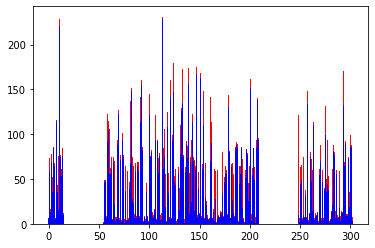

In [25]:
positive = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['topic'].value_counts(sort=False).to_frame(name='positive')
negative = task_b_train_df[task_b_train_df['sentiment'] == 'negative']['topic'].value_counts(sort=False).to_frame(name='negative')
neutral = task_b_train_df[task_b_train_df['sentiment'] == 'neutral']['topic'].value_counts(sort=False).to_frame(name='neutral')
# negative = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'negative'].value_counts(sort=False)
# neutral = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'neutral'].value_counts(sort=False)
joined = positive.join(negative).join(neutral)

joined = joined[(joined['positive'] > 0) & (joined['negative']>0)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(joined)

plt.bar(range(joined.shape[0]), joined['positive'], label='positive', color='blue')
plt.bar(range(joined.shape[0]), joined['negative'], label='negative', color='red', bottom=joined['positive'])

In [0]:
# save dataset as csv file
task_b_train_df.to_csv('coba_train_b', sep='\t')